In [1]:
# packages
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
from functools import reduce
import itertools
from tqdm import tqdm

from sklearn.utils import resample
from scipy.stats import mannwhitneyu, median_test, chi2_contingency

# # local
from nb_util import autoreload, add_dirs
# autoreload()

add_dirs(['../'])
from nash_util import concordance_stats as cs
from nash_util import nash_definitions as nd
from nash_util import nash_changes as nc

from atlas_nash_util import NASHEndpoint, PrimaryEndpointStats, tw, comb_two_strata


add_dirs(['~/Projects/Code/ml-platform'])
from pathai.api.slides import slides_base

In [2]:
per_subject = pd.read_csv('REFDATA/WORKINGDATA/ATLAS_PER_SUBJECT_V3.csv')

In [3]:
ps_main = per_subject[per_subject['TRT01A'].isin(['GS-0976 + GS-9674','Placebo'])].copy()

In [4]:
ps_main.columns

Index(['USUBJID', 'HE_ID_BL', 'TRICHROME_ID_BL', 'HE_ID_W48',
       'TRICHROME_ID_W48', 'TRT01A', 'PE48NRI', 'FI48NRI', 'NAS48NRI',
       'HS48OC', 'LI48OC', 'HB48OC', 'DIABN', 'NR48NRI', 'CIRRCATN',
       'GNN BALLOONING_CONTINUOUS_SCORE_HE_BL', 'GNN BALLOONING_SCORE_HE_BL',
       'GNN LOBULAR_CONTINUOUS_SCORE_HE_BL', 'GNN LOBULAR_SCORE_HE_BL',
       'GNN STEATOSIS_CONTINUOUS_SCORE_HE_BL', 'GNN STEATOSIS_SCORE_HE_BL',
       'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE_BL',
       'GNN BALLOONING_CONTINUOUS_SCORE_HE_W48', 'GNN BALLOONING_SCORE_HE_W48',
       'GNN LOBULAR_CONTINUOUS_SCORE_HE_W48', 'GNN LOBULAR_SCORE_HE_W48',
       'GNN STEATOSIS_CONTINUOUS_SCORE_HE_W48', 'GNN STEATOSIS_SCORE_HE_W48',
       'AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE_W48',
       'GNN CRN_CONTINUOUS_SCORE_TRICHROME_BL', 'GNN CRN_SCORE_TRICHROME_BL',
       'AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME_BL',
       'GNN CRN_CONTINUOUS_SCORE_TRIC

In [5]:
cd = {
    'f':'GNN CRN_SCORE_TRICHROME',
    'i':'GNN LOBULAR_SCORE_HE',
    'b':'GNN BALLOONING_SCORE_HE',
    's':'GNN STEATOSIS_SCORE_HE',
}

tp = {
    'pre':'_BL',
    'post':'_W48',
}

pep = NASHEndpoint(cd=cd, tp=tp)

ps_main['Fibrosis Reduction'] = ps_main.apply(pep.fib_red, axis=1)
ps_main['Fibrosis Reduction Stable NAS'] = ps_main.apply(pep.fib_red_no_worse_nas, axis=1)
ps_main['NAS 2pt Reduction'] = ps_main.apply(pep.nas_2pt_red, axis=1)
ps_main['NASH Resolution'] = ps_main.apply(pep.nash_res_no_worse_fib, axis=1)
ps_main['NASH Resolution BL'] = ps_main.apply(pep.nash_res_bl, axis=1)

In [6]:
test = ps_main.copy()


In [7]:
ps_main['CIRRCATN_AIM'] = ps_main.apply(pep.nash_f4_bl, axis=1)

ps_main['MANUAL STRATA'] = ps_main.apply(lambda r: comb_two_strata(r,'DIABN','CIRRCATN'),axis=1)
ps_main['AIM STRATA'] = ps_main.apply(lambda r: comb_two_strata(r,'DIABN','CIRRCATN_AIM'),axis=1)


In [8]:
# only matched subs

treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()

test = test[test[treat_col].isin([placebo,treat])]
test = test[~test['Fibrosis Reduction Stable NAS'].isna()]

matched_pep_stats = PrimaryEndpointStats(test,treat_col,placebo,treat)

matched_pep_stats.get_stats('Fibrosis Reduction',strata = ['AIM STRATA'])
matched_pep_stats.get_stats('FI48NRI',strata = ['MANUAL STRATA'])


matched_pep_stats.get_stats('NAS 2pt Reduction',strata = ['AIM STRATA'])
matched_pep_stats.get_stats('NAS48NRI',strata = ['MANUAL STRATA'])


matched_pep_stats.get_stats('Fibrosis Reduction Stable NAS',strata = ['AIM STRATA'])
matched_pep_stats.get_stats('PE48NRI',strata = ['MANUAL STRATA'])

matched_pep_stats.get_stats('NASH Resolution',strata = ['AIM STRATA'])
matched_pep_stats.get_stats('NR48NRI',strata = ['MANUAL STRATA'])

matched_pep_stats.stats_df

,End Point,N GS-0976 + GS-9674,N Placebo,N Respond GS-0976 + GS-9674,N Respond Placebo,Response Rate GS-0976 + GS-9674,Response Rate Placebo,OR,OR (LB),OR (UB),CMH p,CHISQ p
0,Fibrosis Reduction,62,37,18,6,0.290323,0.162162,2.396808,0.825684,6.957496,0.104918,0.149990
1,FI48NRI,62,37,13,5,0.209677,0.135135,1.908192,0.604112,6.027360,0.264569,0.352199
2,NAS 2pt Reduction,62,37,37,9,0.596774,0.243243,5.081032,1.977494,13.055357,0.000550,0.000645
3,NAS48NRI,62,37,22,4,0.354839,0.108108,5.680659,1.595343,20.227549,0.005021,0.006957
4,Fibrosis Reduction Stable NAS,62,37,17,6,0.274194,0.162162,2.165973,0.746895,6.281257,0.151683,0.201610
5,PE48NRI,62,37,12,4,0.193548,0.108108,2.221472,0.644543,7.656493,0.196285,0.263857
6,NASH Resolution,62,37,15,5,0.241935,0.135135,2.709048,0.829647,8.845860,0.101241,0.200391
7,NR48NRI,62,37,3,0,0.048387,0.000000,inf,NaN,NaN,0.154531,0.174218


In [9]:
# only matched & NASH BL subs

treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()

test = test[test[treat_col].isin([placebo,treat])]

test = test[~test['NASH Resolution BL'].isna()]
test['NASH Resolution BL'] = test['NASH Resolution BL'].astype(bool)
test = test[~test['NASH Resolution BL']]

test = test[~test['Fibrosis Reduction Stable NAS'].isna()]

matched_nash_pep_stats = PrimaryEndpointStats(test,treat_col,placebo,treat)

matched_nash_pep_stats.get_stats('Fibrosis Reduction',strata = ['AIM STRATA'])
matched_nash_pep_stats.get_stats('FI48NRI',strata = ['MANUAL STRATA'])


matched_nash_pep_stats.get_stats('NAS 2pt Reduction',strata = ['AIM STRATA'])
matched_nash_pep_stats.get_stats('NAS48NRI',strata = ['MANUAL STRATA'])


matched_nash_pep_stats.get_stats('Fibrosis Reduction Stable NAS',strata = ['AIM STRATA'])
matched_nash_pep_stats.get_stats('PE48NRI',strata = ['MANUAL STRATA'])

matched_nash_pep_stats.stats_df

,End Point,N GS-0976 + GS-9674,N Placebo,N Respond GS-0976 + GS-9674,N Respond Placebo,Response Rate GS-0976 + GS-9674,Response Rate Placebo,OR,OR (LB),OR (UB),CMH p,CHISQ p
0,Fibrosis Reduction,58,33,16,6,0.275862,0.181818,2.065000,0.694853,6.136877,0.191609,0.313760
1,FI48NRI,58,33,10,5,0.172414,0.151515,1.419386,0.429144,4.694592,0.563286,0.796160
2,NAS 2pt Reduction,58,33,37,8,0.637931,0.242424,5.664820,2.105222,15.243135,0.000410,0.000286
3,NAS48NRI,58,33,21,3,0.362069,0.090909,7.621978,1.739366,33.399834,0.003646,0.004771
4,Fibrosis Reduction Stable NAS,58,33,16,6,0.275862,0.181818,2.065000,0.694853,6.136877,0.191609,0.313760
5,PE48NRI,58,33,10,4,0.172414,0.121212,1.830895,0.512304,6.543330,0.344645,0.515157


In [67]:
# using all subs
treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()

test = test[test[treat_col].isin([placebo,treat])]

all_pep_stats = PrimaryEndpointStats(test,treat_col,placebo,treat)

all_pep_stats.get_stats('Fibrosis Reduction',strata = ['AIM STRATA'])
all_pep_stats.get_stats('FI48NRI',strata = ['MANUAL STRATA'])


all_pep_stats.get_stats('NAS 2pt Reduction',strata = ['AIM STRATA'])
all_pep_stats.get_stats('NAS48NRI',strata = ['MANUAL STRATA'])


all_pep_stats.get_stats('Fibrosis Reduction Stable NAS',strata = ['AIM STRATA'])
all_pep_stats.get_stats('PE48NRI',strata = ['MANUAL STRATA'])

all_pep_stats.stats_df

,End Point,N GS-0976 + GS-9674,N Placebo,N Respond GS-0976 + GS-9674,N Respond Placebo,Response Rate GS-0976 + GS-9674,Response Rate Placebo,OR,OR (LB),OR (UB),CMH p,CHISQ p
0,Fibrosis Reduction,62,37,18,6,0.290323,0.162162,2.396808,0.825684,6.957496,0.104918,0.149990
1,FI48NRI,74,39,14,5,0.189189,0.128205,1.681140,0.544053,5.194773,0.364810,0.409901
2,NAS 2pt Reduction,74,39,48,10,0.648649,0.256410,5.690678,2.343950,13.815917,0.000081,0.000073
3,NAS48NRI,73,39,24,4,0.328767,0.102564,5.178480,1.500027,17.877448,0.006688,0.008444
4,Fibrosis Reduction Stable NAS,62,37,17,6,0.274194,0.162162,2.165973,0.746895,6.281257,0.151683,0.201610
5,PE48NRI,74,39,13,4,0.175676,0.102564,1.972504,0.585737,6.642529,0.267443,0.301367


In [68]:
# continuous change features
cdc = {
    # main
    'f':'GNN CRN_CONTINUOUS_SCORE_TRICHROME',
    'i':'GNN LOBULAR_CONTINUOUS_SCORE_HE',
    'b':'GNN BALLOONING_CONTINUOUS_SCORE_HE',
    's':'GNN STEATOSIS_CONTINUOUS_SCORE_HE',
    # exp
    'pi':"AREA PROP [[PORTAL INFLAMMATION] OVER [TISSUE]] IN [TISSUE]_HE",
    'cpa':"AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME",
    # comb
    'nas':'CNAS'
}
ps_main['CNAS_BL'] = ps_main[['GNN LOBULAR_CONTINUOUS_SCORE_HE_BL','GNN BALLOONING_CONTINUOUS_SCORE_HE_BL','GNN STEATOSIS_CONTINUOUS_SCORE_HE_BL']].sum(axis=1)
ps_main['CNAS_W48'] = ps_main[['GNN LOBULAR_CONTINUOUS_SCORE_HE_W48','GNN BALLOONING_CONTINUOUS_SCORE_HE_W48','GNN STEATOSIS_CONTINUOUS_SCORE_HE_W48']].sum(axis=1)
for k, v in cdc.items():
    change_col = v + '_CHANGE'
    pct_change_col = v + '_PCG'
    ps_main[change_col] = ps_main[v+tp['post']] - ps_main[v+tp['pre']]
    ps_main[pct_change_col] = ps_main[change_col]/ps_main[v+tp['pre']]

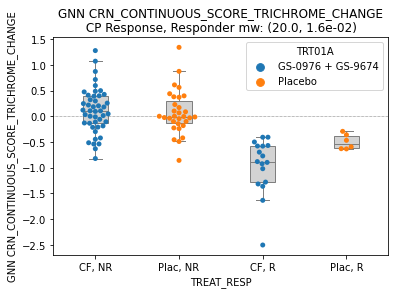

In [88]:
# only matched & NASH BL subs, aim break out

treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()

test = test[test[treat_col].isin([placebo,treat])]

# test = test[~test['NASH Resolution BL'].isna()]
# test['NASH Resolution BL'] = test['NASH Resolution BL'].astype(bool)
# test = test[~test['NASH Resolution BL']]

test = test[~test['Fibrosis Reduction Stable NAS'].isna()]

# test = test[test['Fibrosis Reduction Stable NAS'].astype(bool)]

test['TREAT_RESP'] = test.apply(lambda r: comb_two_strata(r,treat_col,'Fibrosis Reduction Stable NAS'),axis=1)

cep = 'GNN CRN_CONTINUOUS_SCORE_TRICHROME_CHANGE'

ax = sns.boxplot(data=test,
                 y = cep,
                 x = 'TREAT_RESP',
                 saturation=0, width=.3, linewidth=1, fliersize=0, color='lightgray')
        
ax = sns.swarmplot(data=test, x='TREAT_RESP', y=cep, hue=treat_col)


test = test[test['Fibrosis Reduction Stable NAS']]
x0 = test[test[treat_col]==placebo][cep].dropna()
x1 = test[test[treat_col]==treat][cep].dropna()
mw,p_mw = mannwhitneyu(x0, x1)

stats_str =  f"\n CP Response, Responder mw: ({np.around(mw,3)}, {p_mw:.1e}) "
ax.set_title(f'{cep}'+stats_str)
# ax.set_ylabel(tw(ax.get_ylabel(),40))
# ax.set_xlabel(tw(ax.get_xlabel(),60))
ax.set_xticklabels(['CF, NR', 'Plac, NR', 'CF, R', 'Plac, R'])

ax.axhline(0, ls=':', lw=.5, c='k', zorder=0)
plt.show()

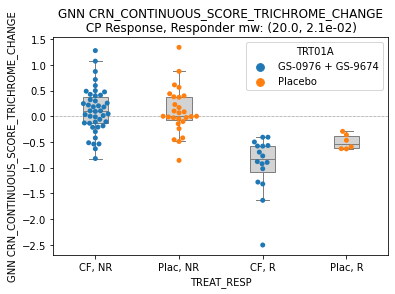

In [78]:
# only matched & NASH BL subs, aim break out

treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()

test = test[test[treat_col].isin([placebo,treat])]

test = test[~test['NASH Resolution BL'].isna()]
test['NASH Resolution BL'] = test['NASH Resolution BL'].astype(bool)
test = test[~test['NASH Resolution BL']]

test = test[~test['Fibrosis Reduction Stable NAS'].isna()]

# test = test[test['Fibrosis Reduction Stable NAS'].astype(bool)]

test['TREAT_RESP'] = test.apply(lambda r: comb_two_strata(r,treat_col,'Fibrosis Reduction Stable NAS'),axis=1)

cep = 'GNN CRN_CONTINUOUS_SCORE_TRICHROME_CHANGE'

ax = sns.boxplot(data=test,
                 y = cep,
                 x = 'TREAT_RESP',
                 saturation=0, width=.3, linewidth=1, fliersize=0, color='lightgray')
        
ax = sns.swarmplot(data=test, x='TREAT_RESP', y=cep, hue=treat_col)


test = test[test['Fibrosis Reduction Stable NAS']]
x0 = test[test[treat_col]==placebo][cep].dropna()
x1 = test[test[treat_col]==treat][cep].dropna()
mw,p_mw = mannwhitneyu(x0, x1)

stats_str =  f"\n CP Response, Responder mw: ({np.around(mw,3)}, {p_mw:.1e}) "
ax.set_title(f'{cep}'+stats_str)
# ax.set_ylabel(tw(ax.get_ylabel(),40))
# ax.set_xlabel(tw(ax.get_xlabel(),60))
ax.set_xticklabels(['CF, NR', 'Plac, NR', 'CF, R', 'Plac, R'])

ax.axhline(0, ls=':', lw=.5, c='k', zorder=0)
plt.show()

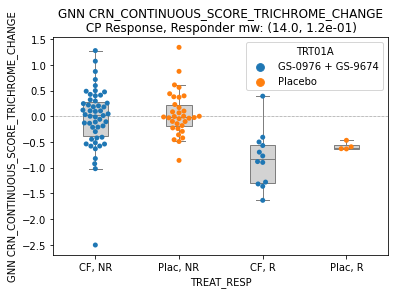

In [79]:
# only matched & NASH BL subs, aim break out

treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()

test = test[test[treat_col].isin([placebo,treat])]

# test = test[~test['NASH Resolution BL'].isna()]
# test['NASH Resolution BL'] = test['NASH Resolution BL'].astype(bool)
# test = test[~test['NASH Resolution BL']]

test = test[~test['PE48NRI'].isna()]

# test = test[test['Fibrosis Reduction Stable NAS'].astype(bool)]

test['TREAT_RESP'] = test.apply(lambda r: comb_two_strata(r,treat_col,'PE48NRI'),axis=1)

cep = 'GNN CRN_CONTINUOUS_SCORE_TRICHROME_CHANGE'

ax = sns.boxplot(data=test,
                 y = cep,
                 x = 'TREAT_RESP',
                 saturation=0, width=.3, linewidth=1, fliersize=0, color='lightgray')
        
ax = sns.swarmplot(data=test, x='TREAT_RESP', y=cep, hue=treat_col)


test = test[test['PE48NRI']=='Y']
x0 = test[test[treat_col]==placebo][cep].dropna()
x1 = test[test[treat_col]==treat][cep].dropna()
mw,p_mw = mannwhitneyu(x0, x1)

stats_str =  f"\n CP Response, Responder mw: ({np.around(mw,3)}, {p_mw:.1e}) "
ax.set_title(f'{cep}'+stats_str)
# ax.set_ylabel(tw(ax.get_ylabel(),40))
# ax.set_xlabel(tw(ax.get_xlabel(),60))
ax.set_xticklabels(['CF, NR', 'Plac, NR', 'CF, R', 'Plac, R'])

ax.axhline(0, ls=':', lw=.5, c='k', zorder=0)
plt.show()

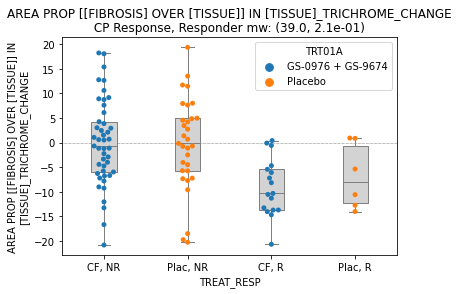

In [89]:
cep = 'AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME_CHANGE'

# only matched & NASH BL subs, aim break out

treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()

test = test[test[treat_col].isin([placebo,treat])]

# test = test[~test['NASH Resolution BL'].isna()]
# test['NASH Resolution BL'] = test['NASH Resolution BL'].astype(bool)
# test = test[~test['NASH Resolution BL']]

test = test[~test['Fibrosis Reduction Stable NAS'].isna()]

# test = test[test['Fibrosis Reduction Stable NAS'].astype(bool)]

test['TREAT_RESP'] = test.apply(lambda r: comb_two_strata(r,treat_col,'Fibrosis Reduction Stable NAS'),axis=1)


ax = sns.boxplot(data=test,
                 y = cep,
                 x = 'TREAT_RESP',
                 saturation=0, width=.3, linewidth=1, fliersize=0, color='lightgray')
        
ax = sns.swarmplot(data=test, x='TREAT_RESP', y=cep, hue=treat_col)


test = test[test['Fibrosis Reduction Stable NAS']]
x0 = test[test[treat_col]==placebo][cep].dropna()
x1 = test[test[treat_col]==treat][cep].dropna()
mw,p_mw = mannwhitneyu(x0, x1)

stats_str =  f"\n CP Response, Responder mw: ({np.around(mw,3)}, {p_mw:.1e}) "
ax.set_title(f'{cep}'+stats_str)
ax.set_ylabel(tw(ax.get_ylabel(),40))
# ax.set_xlabel(tw(ax.get_xlabel(),60))
ax.set_xticklabels(['CF, NR', 'Plac, NR', 'CF, R', 'Plac, R'])

ax.axhline(0, ls=':', lw=.5, c='k', zorder=0)
plt.show()

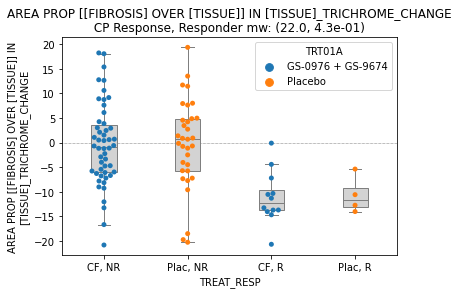

In [90]:
cep = 'AREA PROP [[FIBROSIS] OVER [TISSUE]] IN [TISSUE]_TRICHROME_CHANGE'

# only matched & NASH BL subs, aim break out

treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()

test = test[test[treat_col].isin([placebo,treat])]

# test = test[~test['NASH Resolution BL'].isna()]
# test['NASH Resolution BL'] = test['NASH Resolution BL'].astype(bool)
# test = test[~test['NASH Resolution BL']]

test = test[~test['PE48NRI'].isna()]

# test = test[test['Fibrosis Reduction Stable NAS'].astype(bool)]

test['TREAT_RESP'] = test.apply(lambda r: comb_two_strata(r,treat_col,'PE48NRI'),axis=1)


ax = sns.boxplot(data=test,
                 y = cep,
                 x = 'TREAT_RESP',
                 saturation=0, width=.3, linewidth=1, fliersize=0, color='lightgray')
        
ax = sns.swarmplot(data=test, x='TREAT_RESP', y=cep, hue=treat_col)


test = test[test['PE48NRI']=='Y']
x0 = test[test[treat_col]==placebo][cep].dropna()
x1 = test[test[treat_col]==treat][cep].dropna()
mw,p_mw = mannwhitneyu(x0, x1)

stats_str =  f"\n CP Response, Responder mw: ({np.around(mw,3)}, {p_mw:.1e}) "
ax.set_title(f'{cep}'+stats_str)
ax.set_ylabel(tw(ax.get_ylabel(),40))
# ax.set_xlabel(tw(ax.get_xlabel(),60))
ax.set_xticklabels(['CF, NR', 'Plac, NR', 'CF, R', 'Plac, R'])

ax.axhline(0, ls=':', lw=.5, c='k', zorder=0)
plt.show()

# Primary Endpoint Subsets
- [ ] change strat to exclude BL F4


In [12]:
dfs = []
# only matched subs
treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()

test = test[test[treat_col].isin([placebo,treat])]
test = test[~test['Fibrosis Reduction Stable NAS'].isna()]

matched_pep_stats = PrimaryEndpointStats(test,treat_col,placebo,treat)

matched_pep_stats.get_stats('Fibrosis Reduction',strata = ['AIM STRATA'])
matched_pep_stats.get_stats('FI48NRI',strata = ['MANUAL STRATA'])


matched_pep_stats.get_stats('NAS 2pt Reduction',strata = ['AIM STRATA'])
matched_pep_stats.get_stats('NAS48NRI',strata = ['MANUAL STRATA'])


matched_pep_stats.get_stats('Fibrosis Reduction Stable NAS',strata = ['AIM STRATA'])
matched_pep_stats.get_stats('PE48NRI',strata = ['MANUAL STRATA'])

a = matched_pep_stats.stats_df
a['Subset'] = 'All'
a['Included'] = 'Matched Subjects'
dfs.append(a)



# using all subs
treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()

test = test[test[treat_col].isin([placebo,treat])]

all_pep_stats = PrimaryEndpointStats(test,treat_col,placebo,treat)

all_pep_stats.get_stats('Fibrosis Reduction',strata = ['AIM STRATA'])
all_pep_stats.get_stats('FI48NRI',strata = ['MANUAL STRATA'])


all_pep_stats.get_stats('NAS 2pt Reduction',strata = ['AIM STRATA'])
all_pep_stats.get_stats('NAS48NRI',strata = ['MANUAL STRATA'])


all_pep_stats.get_stats('Fibrosis Reduction Stable NAS',strata = ['AIM STRATA'])
all_pep_stats.get_stats('PE48NRI',strata = ['MANUAL STRATA'])

a = all_pep_stats.stats_df
a['Subset'] = 'All'
a['Included'] = 'All Subjects'
dfs.append(a)

# only matched & NASH BL subs

treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()

test = test[test[treat_col].isin([placebo,treat])]

test = test[~test['NASH Resolution BL'].isna()]
test['NASH Resolution BL'] = test['NASH Resolution BL'].astype(bool)
test = test[~test['NASH Resolution BL']]

test = test[~test['Fibrosis Reduction Stable NAS'].isna()]

matched_nash_pep_stats = PrimaryEndpointStats(test,treat_col,placebo,treat)

matched_nash_pep_stats.get_stats('Fibrosis Reduction',strata = ['AIM STRATA'])
matched_nash_pep_stats.get_stats('FI48NRI',strata = ['MANUAL STRATA'])


matched_nash_pep_stats.get_stats('NAS 2pt Reduction',strata = ['AIM STRATA'])
matched_nash_pep_stats.get_stats('NAS48NRI',strata = ['MANUAL STRATA'])


matched_nash_pep_stats.get_stats('Fibrosis Reduction Stable NAS',strata = ['AIM STRATA'])
matched_nash_pep_stats.get_stats('PE48NRI',strata = ['MANUAL STRATA'])

a = matched_nash_pep_stats.stats_df
a['Subset'] = 'All'
a['Included'] = 'Matched Subjects - AIM BL NASH'
dfs.append(a)


## F4

# only matched subs
treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()
test = test[test['GNN CRN_SCORE_TRICHROME_BL']==4]

test = test[test[treat_col].isin([placebo,treat])]
test = test[~test['Fibrosis Reduction Stable NAS'].isna()]

matched_pep_stats = PrimaryEndpointStats(test,treat_col,placebo,treat)

matched_pep_stats.get_stats('Fibrosis Reduction',strata = ['DIABN'])
matched_pep_stats.get_stats('FI48NRI',strata = ['DIABN'])


matched_pep_stats.get_stats('NAS 2pt Reduction',strata = ['DIABN'])
matched_pep_stats.get_stats('NAS48NRI',strata = ['DIABN'])


matched_pep_stats.get_stats('Fibrosis Reduction Stable NAS',strata = ['DIABN'])
matched_pep_stats.get_stats('PE48NRI',strata = ['DIABN'])

a = matched_pep_stats.stats_df
a['Subset'] = 'F4'
a['Included'] = 'Matched Subjects'
dfs.append(a)



# using all subs
treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()
test = test[test['GNN CRN_SCORE_TRICHROME_BL']==4]

test = test[test[treat_col].isin([placebo,treat])]

all_pep_stats = PrimaryEndpointStats(test,treat_col,placebo,treat)

all_pep_stats.get_stats('Fibrosis Reduction',strata = ['DIABN'])
all_pep_stats.get_stats('FI48NRI',strata = ['DIABN'])


all_pep_stats.get_stats('NAS 2pt Reduction',strata = ['DIABN'])
all_pep_stats.get_stats('NAS48NRI',strata = ['DIABN'])


all_pep_stats.get_stats('Fibrosis Reduction Stable NAS',strata = ['DIABN'])
all_pep_stats.get_stats('PE48NRI',strata = ['DIABN'])

a = all_pep_stats.stats_df
a['Subset'] = 'F4'
a['Included'] = 'All Subjects'
dfs.append(a)

# only matched & NASH BL subs

treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()
test = test[test['GNN CRN_SCORE_TRICHROME_BL']==4]

test = test[test[treat_col].isin([placebo,treat])]

test = test[~test['NASH Resolution BL'].isna()]
test['NASH Resolution BL'] = test['NASH Resolution BL'].astype(bool)
test = test[~test['NASH Resolution BL']]

test = test[~test['Fibrosis Reduction Stable NAS'].isna()]

matched_nash_pep_stats = PrimaryEndpointStats(test,treat_col,placebo,treat)

matched_nash_pep_stats.get_stats('Fibrosis Reduction',strata = ['DIABN'])
matched_nash_pep_stats.get_stats('FI48NRI',strata = ['DIABN'])


matched_nash_pep_stats.get_stats('NAS 2pt Reduction',strata = ['DIABN'])
matched_nash_pep_stats.get_stats('NAS48NRI',strata = ['DIABN'])


matched_nash_pep_stats.get_stats('Fibrosis Reduction Stable NAS',strata = ['DIABN'])
matched_nash_pep_stats.get_stats('PE48NRI',strata = ['DIABN'])

a = matched_nash_pep_stats.stats_df
a['Subset'] = 'F4'
a['Included'] = 'Matched Subjects - AIM BL NASH'
dfs.append(a)



## F3

# only matched subs
treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()
test = test[test['GNN CRN_SCORE_TRICHROME_BL']==3]

test = test[test[treat_col].isin([placebo,treat])]
test = test[~test['Fibrosis Reduction Stable NAS'].isna()]

matched_pep_stats = PrimaryEndpointStats(test,treat_col,placebo,treat)

matched_pep_stats.get_stats('Fibrosis Reduction',strata = ['DIABN'])
matched_pep_stats.get_stats('FI48NRI',strata = ['DIABN'])


matched_pep_stats.get_stats('NAS 2pt Reduction',strata = ['DIABN'])
matched_pep_stats.get_stats('NAS48NRI',strata = ['DIABN'])


matched_pep_stats.get_stats('Fibrosis Reduction Stable NAS',strata = ['DIABN'])
matched_pep_stats.get_stats('PE48NRI',strata = ['DIABN'])

a = matched_pep_stats.stats_df
a['Subset'] = 'F3'
a['Included'] = 'Matched Subjects'
dfs.append(a)



# using all subs
treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()
test = test[test['GNN CRN_SCORE_TRICHROME_BL']==3]

test = test[test[treat_col].isin([placebo,treat])]

all_pep_stats = PrimaryEndpointStats(test,treat_col,placebo,treat)

all_pep_stats.get_stats('Fibrosis Reduction',strata = ['DIABN'])
all_pep_stats.get_stats('FI48NRI',strata = ['DIABN'])


all_pep_stats.get_stats('NAS 2pt Reduction',strata = ['DIABN'])
all_pep_stats.get_stats('NAS48NRI',strata = ['DIABN'])


all_pep_stats.get_stats('Fibrosis Reduction Stable NAS',strata = ['DIABN'])
all_pep_stats.get_stats('PE48NRI',strata = ['DIABN'])

a = all_pep_stats.stats_df
a['Subset'] = 'F3'
a['Included'] = 'All Subjects'
dfs.append(a)

# only matched & NASH BL subs

treat_col = 'TRT01A'
placebo = 'Placebo'
treat = 'GS-0976 + GS-9674'

test = ps_main.copy()
test = test[test['GNN CRN_SCORE_TRICHROME_BL']==3]

test = test[test[treat_col].isin([placebo,treat])]

test = test[~test['NASH Resolution BL'].isna()]
test['NASH Resolution BL'] = test['NASH Resolution BL'].astype(bool)
test = test[~test['NASH Resolution BL']]

test = test[~test['Fibrosis Reduction Stable NAS'].isna()]

matched_nash_pep_stats = PrimaryEndpointStats(test,treat_col,placebo,treat)

matched_nash_pep_stats.get_stats('Fibrosis Reduction',strata = ['DIABN'])
matched_nash_pep_stats.get_stats('FI48NRI',strata = ['DIABN'])


matched_nash_pep_stats.get_stats('NAS 2pt Reduction',strata = ['DIABN'])
matched_nash_pep_stats.get_stats('NAS48NRI',strata = ['DIABN'])


matched_nash_pep_stats.get_stats('Fibrosis Reduction Stable NAS',strata = ['DIABN'])
matched_nash_pep_stats.get_stats('PE48NRI',strata = ['DIABN'])

a = matched_nash_pep_stats.stats_df
a['Subset'] = 'F3'
a['Included'] = 'Matched Subjects - AIM BL NASH'
dfs.append(a)

In [14]:
df_pep = pd.concat(dfs)
df_pep = df_pep.reset_index()
df_pep.to_csv('OUTPUTS/PrimaryEndpointStatsAll_v06282022.csv',index=None)